# IE6511 Homework 7
Done by: Aloisius Stephen and Yang Xiaozhou

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pySOT import *
from poap.controller import SerialController, ThreadController, BasicWorkerThread
from pySOT import Ackley, SyncStrategyNoConstraints, \
    SymmetricLatinHypercube, RBFInterpolant, CubicKernel, \
    LinearTail, CandidateDYCORS

%matplotlib inline

np.set_printoptions(precision=3)

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

## 1. Performances of DDS, LMSRBF (PySOT) and G-MSRBF (PySOT) on the “Ackley” function, within a limited evaluation budget 

### (a)	Implement the DDS algorithm to minimize 20-variable Ackley function. Run 20 trials of 200 cost function evaluations. Save all the best solutions at the end of each trial. Plot the average best Ackley function value over the 20 trials vs. function evaluations, and save the data for this plot as you will add to it in subsequent parts. Please note that you have already done a similar experiment in HW3.

In [14]:
data = Ackley(dim=20)
trial = 20
maxeval = 200

DDS function taken from HW4

In [15]:
def DDS(x_min,x_max,m,x_initial):
    r=0.2
    sBest=x_initial
    sCur=x_initial
    CostBest=data.objfunction(sBest)
    dimen=np.size(x_initial)
    Cost_iter = np.zeros(m)
    Iter = np.zeros(m)
    x_range=x_max-x_min
    k=0
    
    for i in range(0,m):
        sCur=sBest
        Iter[i] = np.int(i+1)
        Cost_iter[i]=CostBest
        for j in range(0,dimen):
            if (np.random.rand(1)<(1-(np.log(i+1)/np.log(m+1)))):
                k=k+1
                sCur[j]=sBest[j]+np.random.randn(1,1)*r*(x_range)
                if(sCur[j]<x_min):
                    sCur[j]=x_min+(x_min-sCur[j])
                    if(sCur[j]>x_max):
                        sCur[j]=x_min
                        
                if(sCur[j]>x_max):
                    sCur[j]=x_max-(sCur[j]-x_max)
                    if(sCur[j]<x_min):
                        sCur[j]=x_max
        
            if(k==0):
                index=np.random.randint(0,dimen)
                sCur[index]=sBest[index]+np.random.randn(1,1)*r*(x_range)
                if(sCur[index]<x_min):
                    sCur[index]=x_min+(x_min-sCur[index])
                    if(sCur[index]>x_max):
                        sCur[index]=x_min
                            
                if(sCur[index]>x_max):
                    sCur[index]=x_max-(sCur[index]-x_max)
                    if(sCur[index]<x_min):
                        sCur[index]=x_max
            k=0
            
            # Update sBest and CostBest if sCur has lower cost
            if(data.objfunction(sCur)<CostBest):
                sBest=sCur
                CostBest=data.objfunction(sBest)
    sol = pd.DataFrame(np.column_stack((Iter,Cost_iter)), columns = ['Iteration','Cost'])
    return sol 

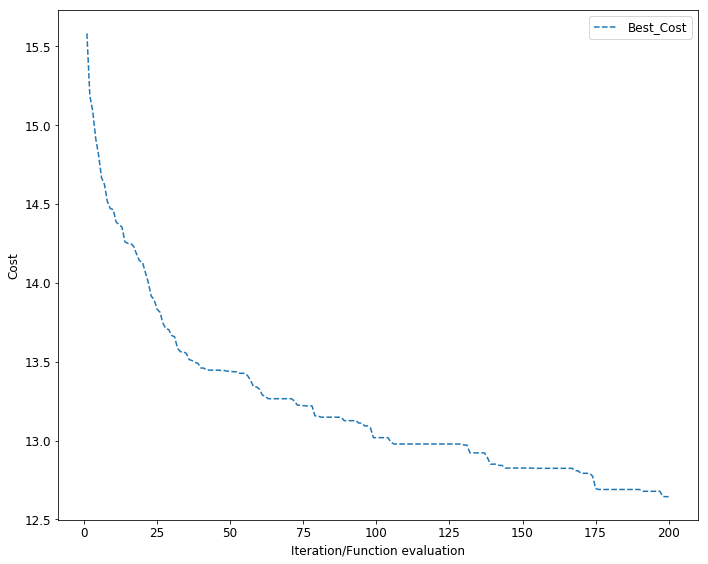

In [19]:
x_init = 10*np.random.rand(data.dim)

Trial_best_DDS = DDS(0,10,maxeval,x_init)

for i  in range(1,trial):
    Trial_best_DDS = Trial_best_DDS.append(DDS(0,10,maxeval,x_init))

#average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_DDS.groupby('Iteration').mean().Cost, '--')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost'])
plt.tight_layout()

LMSRBF

In [59]:
print("\nNumber of threads: 4")
print("Maximum number of evaluations: 200")
print("Sampling method: CandidateSRBF")
print("Experimental design: Symmetric Latin Hypercube")
print("Surrogate: Cubic RBF")

nthreads = 4
maxeval = 200
nsamples = nthreads

print(data.info)

# Create a strategy and a controller
controller = ThreadController()
controller.strategy = \
    SyncStrategyNoConstraints(
        worker_id=0, data=data,
        maxeval=maxeval, nsamples=nsamples,
        exp_design=SymmetricLatinHypercube(dim=data.dim, npts=2*(data.dim+1)),
        response_surface=RBFInterpolant(kernel=CubicKernel, tail=LinearTail,
                                        maxp=maxeval),
        sampling_method=CandidateSRBF(data=data, numcand=100*data.dim))

# Launch the threads and give them access to the objective function
for _ in range(nthreads):
    worker = BasicWorkerThread(controller, data.objfunction)
    controller.launch_worker(worker)

# Run the optimization strategy
result = controller.run()

Iter = np.arange(1,maxeval+1)
Trial_best_LMSRBF = np.column_stack((Iter,np.minimum.accumulate(fvals)))

# Run the rest of the trials (19 trials)
for i  in range(1,trial):
    result = controller.run()
    fvals = np.array([o.value for o in controller.fevals])
    Trial_best_LMSRBF = np.concatenate((Trial_best_LMSRBF, 
                                        np.column_stack((Iter,np.minimum.accumulate(fvals)))), axis=0)
    
Trial_best_LMSRBF_df = pd.DataFrame(Trial_best_LMSRBF, columns = ['Iteration','Cost'])


Number of threads: 4
Maximum number of evaluations: 200
Sampling method: CandidateSRBF
Experimental design: Symmetric Latin Hypercube
Surrogate: Cubic RBF
20-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


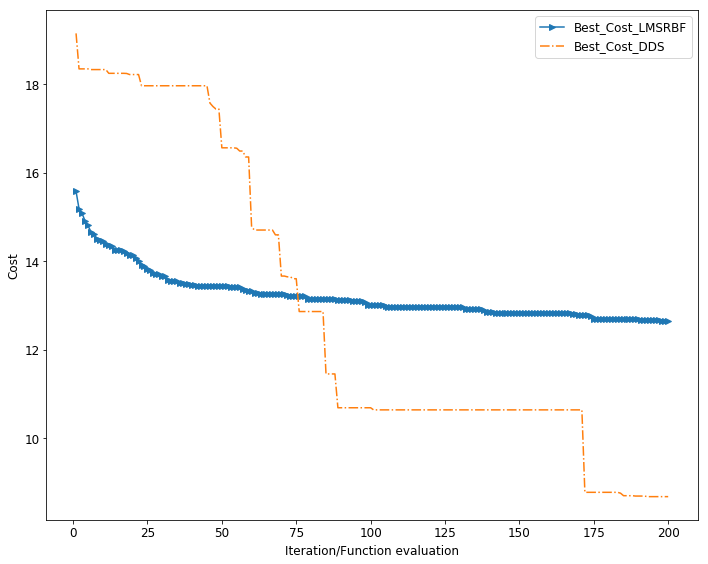

In [64]:
#average of Best_Cost plot
plt.figure(figsize=[10,8])
plt.plot(Trial_best_DDS.groupby('Iteration').mean().Cost, '->')
plt.plot(Trial_best_LMSRBF_df.groupby('Iteration').mean().Cost, '-.')
plt.xlabel('Iteration/Function evaluation')
plt.ylabel('Cost')
plt.legend(['Best_Cost_LMSRBF', 'Best_Cost_DDS'])
plt.tight_layout()

G-MSRBF

## 2.	Using PySOT with different Surrogate Models on the “Ackley” Function (10 points)

## 3.	What are the differences between Global Metric RBF and Local Metric RBF in Regis and Shoemaker (2007)?  Give a succinct list of the ways in which they are different. (5 points)	

Differences: <br>
1. **Candidate points generation:** <br>
    For Global Metric RBF the set of candidate points are generated uniformly at random throughout the domain. <br>
    Under the Local Metric RBF the set of candidate points are generated by adding random perturbation to all the coordinates of the current best solution.
    
2. **Global search:** <br>
    Global Metric RBF carries this out by having a high weight for the distance criterion at the start of its weight cycle. <br> 
    Local Metric RBF does this by having a restart, which is achieved through reinitializing with a different experimental design when the number of consecutive failed iterations exceed a threshold parameter.